In [0]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statistics as stats
import random as rn
import os
import tensorflow.compat.v1 as tf
import keras
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, GaussianNoise, GaussianDropout
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.activations import relu
from keras import initializers as init
from keras.constraints import max_norm
from tensorflow.compat.v1.keras import backend as K
from math import sqrt
from IPython.display import display
from matplotlib.lines import Line2D
from collections import defaultdict

# ensure repeatability
K.clear_session()
tf.reset_default_graph()
warnings.filterwarnings("ignore")

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(23)
rn.seed(23)
tf.random.set_random_seed(23)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

pd.set_option("display.max_columns", None)

Using TensorFlow backend.


In [0]:
# load df
df_HA = pd.read_csv("Lasso_HA_new.csv", index_col=0)
df_HB = pd.read_csv("Lasso_HB_new.csv", index_col=0)
df_P32 = pd.read_csv("Lasso_P3P2.csv", index_col=0)
df_P21 = pd.read_csv("Lasso_P2P1.csv", index_col=0)
df_P10 = pd.read_csv("Lasso_P1P0.csv", index_col=0)
df_N01 = pd.read_csv("Lasso_0N1.csv", index_col=0)
df_N12 = pd.read_csv("Lasso_N2N1.csv", index_col=0)
df_N23 = pd.read_csv("Lasso_N3N2.csv", index_col=0)
full_HA = pd.read_csv("HA_fullchem.csv", index_col=0)
full_HB = pd.read_csv("HB_fullchem.csv", index_col=0)
full_P32 = pd.read_csv("P32_fullchem.csv", index_col=0)
full_P21 = pd.read_csv("P21_fullchem.csv", index_col=0)
full_P10 = pd.read_csv("P10_fullchem.csv", index_col=0)
full_N01 = pd.read_csv("N01_fullchem.csv", index_col=0)
full_N12 = pd.read_csv("N12_fullchem.csv", index_col=0)
full_N23 = pd.read_csv("N23_fullchem.csv", index_col=0)

In [0]:
class NeuralNetwork:
    def data_prep(df, predict=True):
        """
        Function adds two additional descriptor columns for sc type and defect
        site, then standardized and one-hot encodes input and output
        """
        # load labels df - sc type, defect site, compound
        labels = pd.read_csv("labels.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)
        
        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        df = pd.concat([df, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        # seperate x and y values
        y = df.iloc[:, 0:1]
        x = df.iloc[:, 1:100000]

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass
                
        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()
   
        # standardize continuous data
        input_scaler = StandardScaler()
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)

        # standardize outputs (DFT predicted / output)
        output_scaler = StandardScaler()
        y = output_scaler.fit_transform(y)

        # concatenate x and y back to df
        df = pd.DataFrame(np.concatenate((y, x), axis=1))

        return (df, output_scaler)

    def graph_loss_func(epochs, loss, val_loss, dft_train, mean_train, 
                        std_train, dft_test, mean_test, std_test):
    
        test_color = "#ff5042"  #red 
        train_color = "#080bb6"  #blue
        error_color = "#bababa"  #grey
        fig, ax = plt.subplots(figsize=(12, 7))
        x_plot = np.arange(0, epochs)
        for index in range(loss.shape[0]):
            ax.plot(x_plot, loss[index], label="Training Loss", color=train_color, 
                    lw=2)
            ax.plot(x_plot, val_loss[index], label="Validation Loss",
                    color=test_color, lw=2)
        ax.set_xlabel("Epoch Number", fontsize=15)
        ax.set_ylabel("Loss", fontsize=15)
        ax.set_ylim(0, 3)
        ax.set_title('Training/Validation Loss Functions', fontsize=20)
        legend_lines = [Line2D([0], [0], color=train_color, lw=4),
                        Line2D([0], [0], color=test_color, lw=4)]                                
        ax.legend(legend_lines, ["Loss", "Val. Loss"], fontsize=20)
        plt.show()

        #############################################################
        # plot results
        fig, ax = plt.subplots(figsize=(8, 8))
        fig.subplots_adjust(hspace=.125, wspace = 0.125, top=.90)
        fig.suptitle("NN Predictions VS. DFT Calc.", fontsize=20, va='top')
        fig.text(0.5, 0.045, 'DFT Calculations (eV)', ha='center', fontsize=17)
        fig.text(0.045, 0.5, 'Neural Network Prediction (eV)', va='center', rotation='vertical',
                fontsize=17)
        
        subtitle_size=17
        test_alpha = 0.65
        train_alpha = 0.85
        scatter_size = 6.5

        ax.set_title("Transition Level: (-1/-2)", fontsize=subtitle_size)
        ax.errorbar(dft_train, mean_train, yerr=std_train, fmt='o', 
                    label="Train", ecolor=error_color, elinewidth=2.5, 
                    alpha=train_alpha, color=train_color, 
                    markersize=scatter_size, zorder=3)        
        ax.errorbar(dft_test, mean_test, yerr=std_test, fmt='o', 
                    label="Test", ecolor=error_color, elinewidth=2.5, 
                    alpha=test_alpha, color=test_color, markersize=scatter_size,
                    zorder=3)        
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()])]
        ax.plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.legend(fontsize=subtitle_size)
        plt.show()

    def model_eval(model, prediction, x_train, x_test, y_train, y_test, 
                   output_scaler):
        """
        Prints out the RMSE train and test values
        """
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        y_train = output_scaler.inverse_transform(y_train)
        y_test = output_scaler.inverse_transform(y_test)
        pred_train = output_scaler.inverse_transform(pred_train)
        pred_test = output_scaler.inverse_transform(pred_test)
        
        train_RMSE = sqrt(mean_squared_error(y_train, pred_train))
        test_RMSE = sqrt(mean_squared_error(y_test, pred_test))
        #print("- - - - - - - - - - - - - - - - - - - -")
        #print("RMSE Training / Testing (eV):")
        #print("(+3/+2): %.4f / %.4f" % (train_RMSE, test_RMSE))                                    
        #print("- - - - - - - - - - - - - - - - - - - -")
        low_epoch = (np.argmin(prediction.history["val_loss"]) + 1)
        low_val_loss = np.amin(prediction.history["val_loss"])
        low_epoch_train = (np.argmin(prediction.history["loss"]) + 1)
        low_val_loss_train = np.amin(prediction.history["loss"])
        print("Lowest Val. loss: %.4f at %s epochs" % (low_val_loss, low_epoch))
        print("Lowest train loss: %.4f at %s epochs" % (low_val_loss_train, low_epoch_train))
        print("- - - - - - - - - - - - - - - - - - - -")        
        print("")
        return (train_RMSE, test_RMSE, pred_train, pred_test, y_train, y_test)

    def prep_fullchem(df_full):
        # load full chem labels df - sc type, defect site, compound
        labels = pd.read_csv("labels_fullchem.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)

        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        x = pd.concat([df_full, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass
                
        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()
   
        # standardize continuous data
        input_scaler = StandardScaler()
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)

        return (pd.DataFrame(x))

    def run_k_fold(df, epochs, bs, lr, decay, dropout, noise, k_reg, hid_layer, 
                   verbose, folds, repeats, rs, graph, output_scaler, df_full):   
        """
        This functions performs the k_fold stratify split and runs the neural 
        network model for predictions.
        """
        des_labels = pd.read_csv("labels.csv", sep="|")
        des_labels.drop(columns=des_labels.iloc[:, 1:2], inplace=True)
        df = pd.concat([des_labels, df], axis=1)

        enc = OrdinalEncoder(dtype=np.int)
        encode_labels = enc.fit_transform(des_labels)
        labels = pd.DataFrame(encode_labels, columns=["Type", "Site"])
        labels = labels.applymap(str)
        labels = labels[["Type", "Site"]].apply(lambda x: ''.join(x), axis=1)

        # encode the new string col to 0-14 (15 total classes - 3 sctypes x 5 defsites)
        combined_labels = np.array(labels).reshape(-1, 1)
        combined_lables = enc.fit_transform(combined_labels)

        total_folds = 0
        fold_num = 0
        train_RMSE = []
        test_RMSE = []
        loss = []
        val_loss = []
        Y_train = np.empty(0)
        Y_test = np.empty(0)
        PRED_train = np.empty(0)
        PRED_test = np.empty(0)
        full_pred = np.empty(0)
        
        for random in range(1, repeats+1):
            fold_num+=1
            stratified = StratifiedKFold(n_splits=folds, shuffle=True, 
                                         random_state=(random*10))
            for train_index, test_index in stratified.split(df, combined_labels):
                total_folds+=1

                train = df.loc[train_index]
                test = df.loc[test_index]
                
                # train split
                y_train = train.iloc[:, 2:3]
                x_train = train.iloc[:, 3:100000]
                # test split
                y_test = test.iloc[:, 2:3]
                x_test = test.iloc[:, 3:100000]

                # sc type and defect site split
                sub_train_index = ((train.Site=="M_A") +
                                  (train.Site=="M_B"))
                int_train_index = ((train.Site=="M_i_A") +
                                  (train.Site=="M_i_B") +
                                  (train.Site=="M_i_neut"))
                sub_test_index = ((test.Site=="M_A") +
                                  (test.Site=="M_B"))
                int_test_index = ((test.Site=="M_i_A") +
                                  (test.Site=="M_i_B") + 
                                  (test.Site=="M_i_neut"))
                
                sub_train = train.loc[sub_train_index]
                int_train = train.loc[int_train_index]
                sub_test = test.loc[sub_test_index]
                int_test = test.loc[int_test_index]         
                IIVI_train = train.loc[train.Type=="II-VI"]
                IIIV_train = train.loc[train.Type=="III-V"]
                IVIV_train = train.loc[train.Type=="IV-IV"]
                IIVI_test = test.loc[test.Type=="II-VI"]
                IIIV_test = test.loc[test.Type=="III-V"]
                IVIV_test = test.loc[test.Type=="IV-IV"]

                y_sub_test = sub_test.iloc[:, 2:3]
                x_sub_test = sub_test.iloc[:, 3:100000]
                y_int_test = int_test.iloc[:, 2:3]
                x_int_test = int_test.iloc[:, 3:100000]
                y_IIVI_test = sub_test.iloc[:, 2:3]
                x_IIVI_test = sub_test.iloc[:, 3:100000]
                y_IIIV_test = sub_test.iloc[:, 2:3]
                x_IIIV_test = sub_test.iloc[:, 3:100000]
                y_IVIV_test = sub_test.iloc[:, 2:3]
                x_IVIV_test = sub_test.iloc[:, 3:100000]

                input_dim = x_train.shape[1]
                model, prediction = NeuralNetwork.train_model(x_train, y_train, 
                                                              x_test, y_test,
                                                              input_dim, epochs, bs,
                                                              lr, decay, dropout,
                                                              noise, k_reg, 
                                                              hid_layer, verbose)
                # print RMSE values
                print("K-Fold repeat #: " + str(fold_num))
                print("K-Fold ovrall #: " + str(total_folds))
                (train_rmse, test_rmse, 
                pred_train, pred_test,
                y_train, y_test) = NeuralNetwork.model_eval(model,
                                                            prediction,
                                                            x_train, x_test,
                                                            y_train, y_test,
                                                            output_scaler)

                # Predict full 12k points
                full_predict = model.predict(df_full)
                full_predict = output_scaler.inverse_transform(full_predict)
                full_predict = np.array(full_predict)
                full_pred = np.append(full_pred, full_predict)
                
                # append each train and test RMSE
                train_RMSE.append(train_rmse)
                test_RMSE.append(test_rmse)
                loss.append(prediction.history["loss"])
                val_loss.append(prediction.history["val_loss"])

                Y_train = np.append(Y_train, y_train)
                Y_test = np.append(Y_test, y_test)
                PRED_train = np.append(PRED_train, pred_train)
                PRED_test = np.append(PRED_test, pred_test)

        # reshape loss functions to have length of # of epochs for plotting
        loss = np.array(loss).reshape(-1, epochs)
        val_loss = np.array(val_loss).reshape(-1, epochs)

        # reshape and calculate uncertainties for full 12k points
        full_pred = full_pred.reshape(-1, repeats*folds)
        stdev = pd.DataFrame(full_pred.std(axis=1), columns=["Uncertainty"])
        stdev.to_excel(r"Full_chem_uncertainty.xlsx", index=False)

        # Combine training and testing datasets into dictionary
        Y_train = list(Y_train)
        Y_test = list(Y_test)
        PRED_train = list(PRED_train)
        PRED_test = list(PRED_test)

        train_zip = list(zip(Y_train, PRED_train))
        test_zip = list(zip(Y_test, PRED_test))
        train_dic = defaultdict(list)
        test_dic = defaultdict(list)

        for y_training, pred_training in train_zip:
            train_dic[y_training].append(pred_training)
        
        for y_testing, pred_testing in test_zip:
            test_dic[y_testing].append(pred_testing)

        dft_train = np.empty(0)
        mean_train = np.empty(0)
        std_train = np.empty(0)
        dft_test = np.empty(0)
        mean_test = np.empty(0)
        std_test = np.empty(0)

        # calculate and append meand and stdev for each dft datapoint
        for key, values in train_dic.items():
            dft_train = np.append(dft_train, key)
            mean_train = np.append(mean_train, stats.mean(values))
            std_train = np.append(std_train, stats.stdev(values))

        for key, values in test_dic.items():
            dft_test = np.append(dft_test, key)
            mean_test = np.append(mean_test, stats.mean(values))
            std_test = np.append(std_test, stats.stdev(values))

        # graph loss functions
        if graph is True:
            NeuralNetwork.graph_loss_func(epochs, loss, val_loss, 
                                          dft_train, mean_train, std_train,
                                          dft_test, mean_test, std_test)
        else:
            pass

        # calculate mean and stdev of train and test RMSE and display df
        train_RMSE_avg = stats.mean(train_RMSE)
        train_RMSE_stdev = stats.stdev(train_RMSE)
        test_RMSE_avg = stats.mean(test_RMSE)
        test_RMSE_stdev = stats.stdev(test_RMSE)
        summary = pd.DataFrame([train_RMSE, test_RMSE]).T
        summary.columns = ["Train RMSE", "Test RMSE"]
        display(summary)
        print("Average Train RMSE: %.3f +/- %.3f" % (train_RMSE_avg, train_RMSE_stdev))
        print("Average Test RMSE: %.3f +/- %.3f" % (test_RMSE_avg, test_RMSE_stdev))

        return (train_RMSE_avg, test_RMSE_avg)

    def train_model(x_train, y_train, x_test, y_test, input_dim, 
                    epochs, bs, lr, decay, dropout, noise, k_reg,
                    hid_layer, verbose):
        # Create and add layers to model
        model = Sequential()
        #### Input layer
        model.add(Dense(round((input_dim)/2)*2,
                        input_dim=input_dim, 
                        activation='relu',
                        kernel_regularizer=l1(k_reg),
                        #bias_regularizer=l2(k_reg/10),
                        activity_regularizer=l2(k_reg/10)))
        model.add(GaussianNoise(noise))
        model.add(GaussianDropout(dropout))

        ## hidden layers
        for layers in range(hid_layer):
            model.add(Dense(round((input_dim)/2), activation='relu',
                            #kernel_regularizer=l1(k_reg),
                            #bias_regularizer=l2(k_reg/100),
                            activity_regularizer=l2(k_reg/100)))
            # model.add(GaussianNoise(noise))
            # model.add(GaussianDropout(dropout))

        ## output layers
        model.add(Dense(1))

        # configure optimizer & compile model
        opt = Adam(lr=lr, decay=decay)
        model.compile(loss="mse", optimizer=opt)

        # summarize model
        # print(model.summary())

        # train model
        prediction = model.fit(x_train, y_train,
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              batch_size=bs,
                              verbose=verbose)
        
        return (model, prediction)

In [0]:
## parameters
k_folds = 5
repetition = 20

epochs = 1200
batch_size = 100
learning_rate = 5e-3
adam_decay = 5e-2
dropout = 0.325
noise = 7.5e-2
kernal_regularizer = 0.0055
hidden_layers = 2
random_state = 20

verbose = 0
plot_graph=True

df columns: 57
full df columns: 56

K-Fold repeat #: 1
K-Fold ovrall #: 1
Lowest Val. loss: 0.2511 at 1200 epochs
Lowest train loss: 0.2790 at 1126 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 2
Lowest Val. loss: 0.2769 at 1200 epochs
Lowest train loss: 0.2950 at 1100 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 3
Lowest Val. loss: 0.2725 at 1197 epochs
Lowest train loss: 0.2845 at 1198 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 4
Lowest Val. loss: 0.2347 at 1200 epochs
Lowest train loss: 0.2816 at 1117 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 5
Lowest Val. loss: 0.2943 at 1186 epochs
Lowest train loss: 0.2795 at 1155 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 2
K-Fold ovrall #: 6
Lowest Val. loss: 0.2893 at 1190 epochs
Lowest train loss: 0.2760 at 1183 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fo

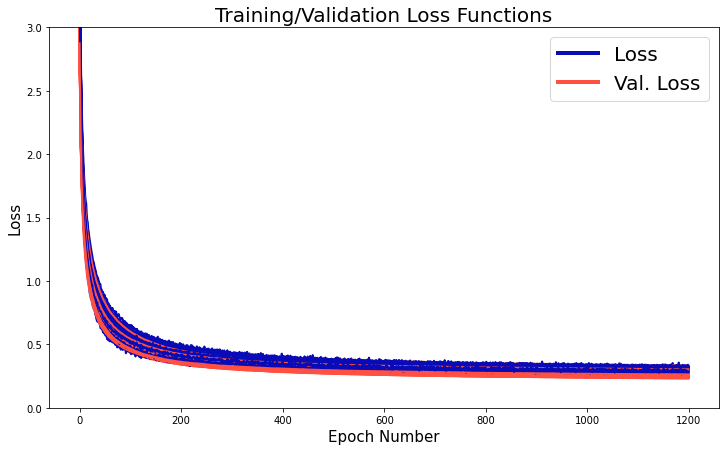

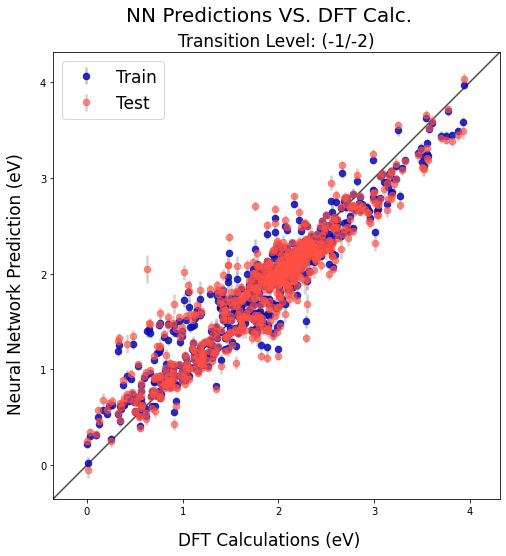

,Train RMSE,Test RMSE
0,0.234106,0.259252
1,0.225130,0.271602
2,0.227928,0.265827
3,0.233244,0.240316
4,0.221299,0.299805
...,...,...
95,0.229302,0.298048
96,0.233670,0.244754
97,0.229013,0.280030
98,0.217025,0.302256


Average Train RMSE: 0.229 +/- 0.004
Average Test RMSE: 0.274 +/- 0.021


In [0]:
# data preprocessing
df, output_scaler = NeuralNetwork.data_prep(df_N12)
df_full = NeuralNetwork.prep_fullchem(full_N12)
print("df columns: " + str(df.shape[1]))
print("full df columns: " + str(df_full.shape[1]))
print("")

# run k-fold
(train_RMSE,
 test_RMSE) = NeuralNetwork.run_k_fold(df, epochs=epochs, bs=batch_size, 
                                       lr=learning_rate, decay=adam_decay, 
                                       dropout=dropout, noise=noise, 
                                       k_reg=kernal_regularizer, 
                                       hid_layer=hidden_layers, verbose=verbose,
                                       folds=k_folds, repeats=repetition,
                                       rs=random_state, graph=plot_graph, 
                                       output_scaler=output_scaler,
                                       df_full=df_full)